In [100]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Loading Data

In [101]:
train_dt = pd.read_csv("C:/Users/z2m09/Desktop/titanic/train.csv") 
dtypes = train_dt.dtypes # Get the dtypes
cols = train_dt.columns # Get the columns      

In [102]:
train_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [103]:
dtype_dictionary = {} 
for c in cols:
    if str(dtypes[c]) == 'int64':
        dtype_dictionary[c] = 'int16'
    elif str(dtypes[c]) == 'float64':
        dtype_dictionary[c] = 'float16'
    else:
        dtype_dictionary[c] = str(dtypes[c])

In [104]:
# Load Data with increased speed and reduced memory.
train = pd.read_csv("C:/Users/z2m09/Desktop/titanic/train.csv", dtype=dtype_dictionary)
test = pd.read_csv("C:/Users/z2m09/Desktop/titanic/test.csv", dtype=dtype_dictionary)

In [105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int16  
 1   Survived     891 non-null    int16  
 2   Pclass       891 non-null    int16  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float16
 6   SibSp        891 non-null    int16  
 7   Parch        891 non-null    int16  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float16
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float16(2), int16(5), object(5)
memory usage: 47.1+ KB


In [106]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.312500,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925781,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.093750,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.046875,NaN,S


In [107]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


#### If your DataFrame contains lots of empty values or missing values or NANs you can reduce their memory footprint by converting them to Sparse Series. For example: 

In [108]:
series1 = train_dt['Cabin']

In [109]:
series1.memory_usage(index=False, deep=True)

34344

In [110]:
series1.dropna()

1              C85
3             C123
6              E46
10              G6
11            C103
          ...     
871            D35
872    B51 B53 B55
879            C50
887            B42
889           C148
Name: Cabin, Length: 204, dtype: object

In [111]:
sparse_series = series1.astype("Sparse[str]")

In [112]:
sparse_series.memory_usage(index=False, deep=True)

29664

# 2. Exploratory Analysis

### Class Distribution
Data are slightly imbalanced. Algorithms should optimize for metrics like F1.

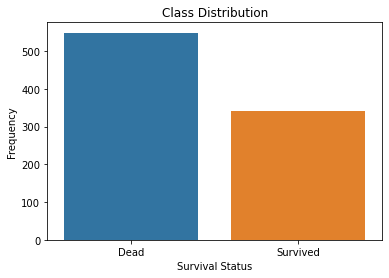

In [113]:
sns.countplot(data=train, x='Survived')
ax = plt.gca()
ax.set_xlabel('Survival Status')
ax.set_xticklabels(['Dead', 'Survived'])
ax.set_ylabel('Frequency')
ax.set_title('Class Distribution')
plt.show()

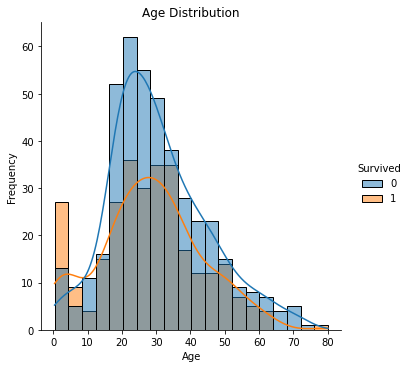

In [114]:
sns.displot(data=train, x='Age', hue='Survived', kde=True)
ax = plt.gca()
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')
ax.set_title('Age Distribution')
plt.show()

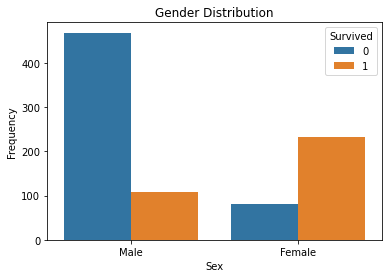

In [115]:
sns.countplot(data=train, x='Sex', hue='Survived')
ax = plt.gca()
ax.set_xlabel('Sex')
ax.set_xticklabels(['Male', 'Female'])
ax.set_ylabel('Frequency')
ax.set_title('Gender Distribution')
plt.show()

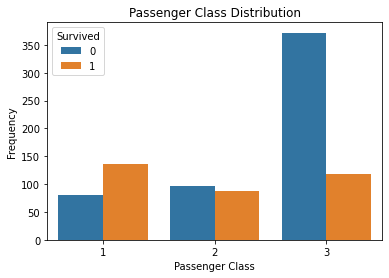

In [116]:
sns.countplot(data=train, x='Pclass', hue='Survived')
ax = plt.gca()
ax.set_xlabel('Passenger Class')
ax.set_ylabel('Frequency')
ax.set_title('Passenger Class Distribution')
plt.show()

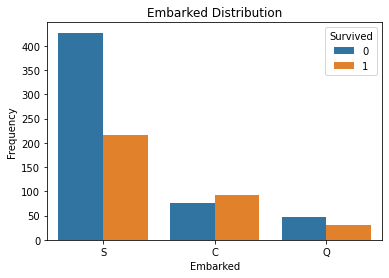

In [117]:
sns.countplot(data=train, x='Embarked', hue='Survived')
ax = plt.gca()
ax.set_xlabel('Embarked')
ax.set_ylabel('Frequency')
ax.set_title('Embarked Distribution')
plt.show()

The distribution of Fare column is too much skewed.

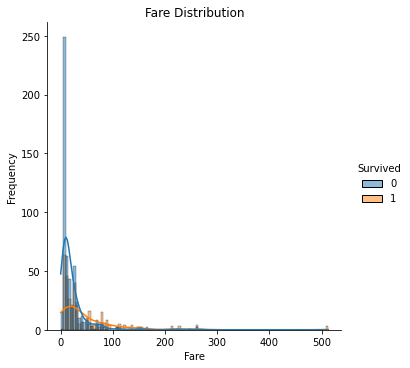

In [118]:
sns.displot(data=train, x='Fare', hue='Survived', kde=True)
ax = plt.gca()
ax.set_xlabel('Fare')
ax.set_ylabel('Frequency')
ax.set_title('Fare Distribution')
plt.show()

Even in the logarithmic scale, the Fare column is skewed, probably due to outliers.

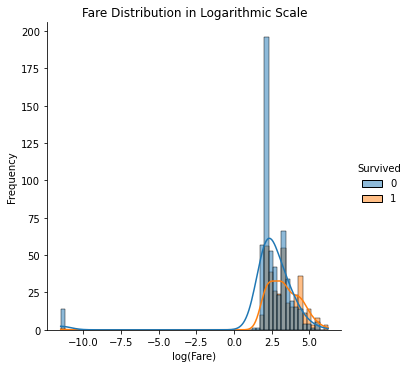

In [119]:
sns.displot(data=train, x=np.log(train.Fare + 0.00001), hue='Survived', kde=True)
ax = plt.gca()
ax.set_xlabel('log(Fare)')
ax.set_ylabel('Frequency')
ax.set_title('Fare Distribution in Logarithmic Scale')
plt.show()

I'm guessing that the Fare values of 0.0 are actually missing values. So, I will impute them with an average value later.

In [120]:
print(min(train.Fare))
print(max(train.Fare))
print(train[train.Fare == 0.0].shape)

0.0
512.5
(15, 12)


### Missing Values
Since 77% of Cabin data is missing, we will simply discard that column. Then we will impute the missing Age values.

In [121]:
(train.isnull().sum() / train.shape[0]) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

**Challange**: **Can you visualize something more? Perhaps some relationships between variables?**

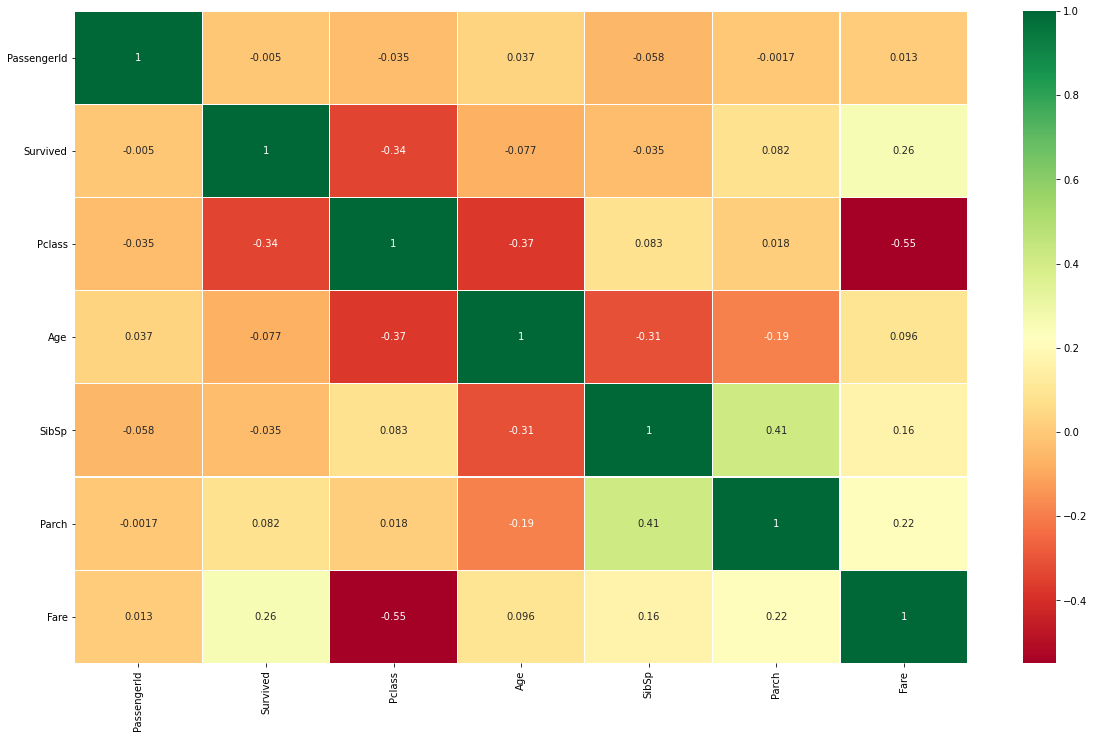

In [131]:
sns.heatmap(train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

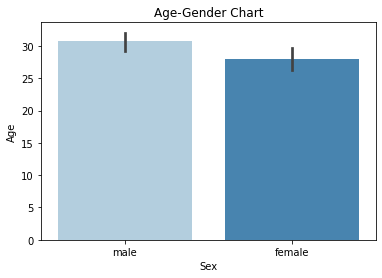

In [129]:
sns.barplot(x = 'Sex',y = 'Age',data = train, palette = "Blues")
plt.title('Age-Gender Chart')
plt.xlabel('Sex')
plt.ylabel('Age')
plt.show()

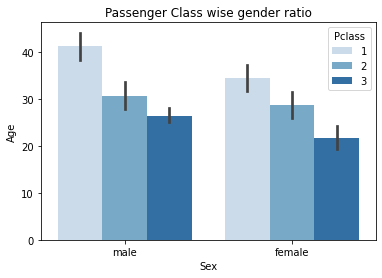

In [130]:
sns.barplot(x = 'Sex',y = 'Age',hue = 'Pclass',data = train, palette = "Blues")
plt.title('Passenger Class wise gender ratio')
plt.xlabel('Sex')
plt.ylabel('Age') 
plt.show()

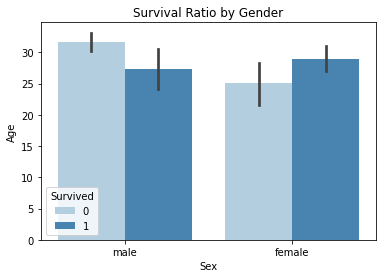

In [132]:
sns.barplot(x = 'Sex',y = 'Age',hue = 'Survived',data = train, palette = "Blues")
plt.title('Survival Ratio by Gender')
plt.xlabel('Sex')
plt.ylabel('Age') 
plt.show()

<AxesSubplot:xlabel='Survived', ylabel='Pclass'>

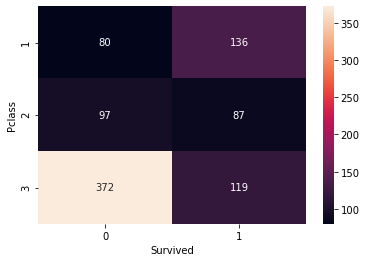

In [133]:
group = train.groupby(['Pclass', 'Survived'])
pclass_survived = group.size().unstack()
 
sns.heatmap(pclass_survived, annot = True, fmt ="d")

<AxesSubplot:xlabel='Fare_Range', ylabel='Survived'>

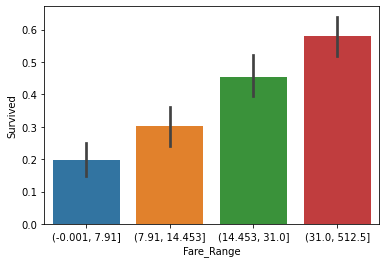

In [134]:
train['Fare_Range'] = pd.qcut(train['Fare'], 4)
 
sns.barplot(x ='Fare_Range', y ='Survived',
data = train)

# 3. Feature Engineering & Preprocessings

Separates features and target variables.

In [135]:
X = train.drop(['Survived'], axis=1)
Y = train[['Survived']]

In [136]:
encoder = LabelEncoder()
Y = encoder.fit_transform(Y.Survived)

In [137]:
# The following class is an example of Scikit-Learn custom transformers. You have already 
# used StandardScaler, MinMaxScaler, etc., which are just some built-in transformers that
# transforms your data.
class ProcessData(BaseEstimator, TransformerMixin):
    def __init__(self, train=True):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print('Transforming data...')
        
        # First we want a deep copy of the dataframe beacuse we do not want to
        # change the original one.
        x_copy = X.copy()
        # Drops passenger Ids, Names, Ticket Numbers, and Cabin Names as they
        # are not the discerning factors.
        x_copy.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
        # Replaces 0.0 fares with average fair. I assume that 0.0 is actually a null value.
        x_copy[x_copy.Fare == 0.0].Fare = np.mean
        # Converts Fare column into a logarithmic scale since its distribution was too skewed.
        x_copy.Fare = np.log(x_copy.Fare + 0.000001)
        # Encodes numeric values into categorical one
        x_copy.Pclass = x_copy.Pclass.map({
            1: 'First',
            2: 'Second',
            3: 'Third'
        })
        # Imputes null Age values with average age and then bins Age into categories.
        x_copy[x_copy.Age.isnull()].Age = np.mean(x_copy.Age)
        bins= [0, 2, 4, 13, 20, 50, 70, 110]
        labels = ['Infant','Toddler','Kid','Teen','Adult', 'Old', 'Venerable']
        x_copy['AgeGroup'] = pd.cut(x_copy['Age'], bins=bins, labels=labels, right=False)
        x_copy.drop(['Age'], axis=1, inplace=True)
        # Gets One Hot Encodings
        x_copy = pd.get_dummies(x_copy)
        
        return x_copy

In [138]:
processor = ProcessData()
processor.fit(X)
x_train_processed = processor.transform(X)
x_test_processed = processor.transform(test)

Transforming data...
Transforming data...


C:\Users\z2m09\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\z2m09\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [141]:
"""
scaler = MinMaxScaler()
scaler.fit(x_train_processed)
x_train_processed = scaler.transform(x_train_processed)
x_test_processed = scaler.transform(x_test_processed)
"""

'\nscaler = MinMaxScaler()\nscaler.fit(x_train_processed)\nx_train_processed = scaler.transform(x_train_processed)\nx_test_processed = scaler.transform(x_test_processed)\n'

In [142]:
print(x_train_processed.shape)
print(x_test_processed.shape)

(891, 22)
(418, 18)


**Challange**: **Can you make this preprocessing more streamlined or automated. You may take help from the following [blog](https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156).**

# 4. Model

`LightGBM` is a popular library of RandomForest. Another one is called `XGboost`. Here we have used `LightGBM` to build a random forest.

**Challange**: **Can you use GridSearch to further tune the hyper-parameters? You can take help from this [blog](https://towardsdatascience.com/hyper-parameter-tuning-in-python-1923797f124f)**

In [143]:
"""
rf_clf = lightgbm.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=8,
    learning_rate=0.01,
    n_estimators=100,
    objective='binary',
    min_split_gain=0.5,
    metric='auc',
    random_state=27
)
"""

"\nrf_clf = lightgbm.LGBMClassifier(\n    boosting_type='gbdt',\n    num_leaves=31,\n    max_depth=8,\n    learning_rate=0.01,\n    n_estimators=100,\n    objective='binary',\n    min_split_gain=0.5,\n    metric='auc',\n    random_state=27\n)\n"

In [146]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(x_train_processed, Y, test_size=0.2, stratify=Y)
#rf_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)],
        #eval_metric='f1', early_stopping_rounds=50)

grid_search = GridSearchCV(RandomForestRegressor(random_state=0),
                           {
                              'n_estimators':np.arange(5,100,5),
                              'max_features':np.arange(0.1,1.0,0.05),
                            
                            },cv=5, scoring="r2",verbose=1,n_jobs=-1
                           )
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                         'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])},
             scoring='r2', verbose=1)

# 5. Evaluation

**Challange**: **Can you draw a confusion matrix and report metrics like precision, recall, and f1 score?**

In [148]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 500, max_depth=12)
rf_clf.fit(X_train, y_train)
predictions = rf_clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, predictions))

Accuracy:  0.7877094972067039


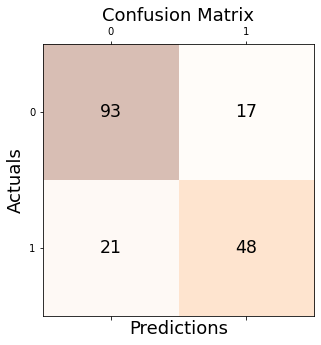

In [149]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()